In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/intermediate/comb_interests_1.csv").drop('Unnamed: 0', axis=1)
df['DATUM:TIJD'] = df['DATUM:TIJD'].apply(pd.to_datetime)

df.rename({'DATUM:TIJD':'TIME'}, axis=1, inplace=True)

Helaas niet op dezelfde dag; geen

    df[df.LOC=='BEERKNMDN'].join(df[df.LOC=='MAASSS'], 'TIME', rsuffix='_r')

In [2]:
import math

# TODO maybe keys and must-be keys?
def close_in_time_gen(a, b, keys, time='TIME', time_fun=lambda x:x, dt=0):
    ga = zip(time_fun(a[time]), zip(*[a[k] for k in keys]))
    gb = zip(time_fun(b[time]), zip(*[b[k] for k in keys]))

    ta,va = next(ga)
    tb,vb = next(gb)

    while ta and tb:
        if ta < tb:
            nta,nva = next(ga)
            if nta > tb:  #Past it, figure closest.
                if nta - tb > tb - ta:
                    yield [ta,tb, *va,*vb]
                    tb,vb = next(gb)
                else:
                    yield [nta,tb, *nva,*vb]
            ta,va = nta, nva
        else:
            ntb,nvb = next(gb)
            if ntb > ta:  #Past it, figure closest.
                if ntb - ta > ta - tb:
                    yield [ta,tb, *va,*vb]
                    ta,va = next(ga)
                else:
                    yield [ta,ntb, *va,*nvb]
            tb,vb = ntb, nvb

def close_in_time_df(a, b, keys, time='TIME', rsuffix='_r', dt=0, time_fun=lambda x:x):
    return pd.DataFrame(list(close_in_time_gen(a,b,keys, time=time, dt=dt, time_fun=time_fun)),
                        columns=['T1','T2',*keys, *[k + rsuffix for k in keys]])

Veel volgen er vrij strak.

/home/jasper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: generator 'close_in_time_gen' raised StopIteration


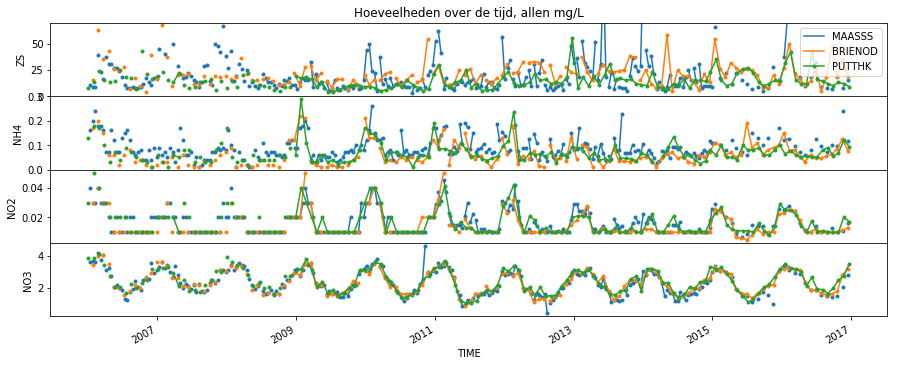

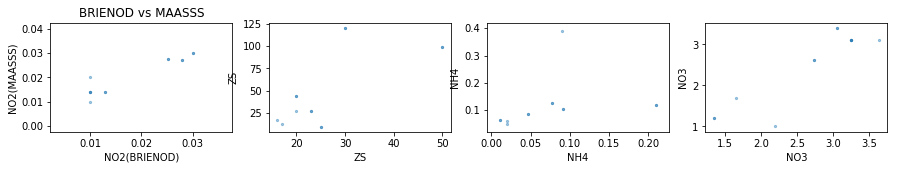

In [18]:
def vergelijk_locaties(locs, substs=['ZS', 'NH4','NO2', 'NO3'], figsize=(15,6)):
    fig,ax = plt.subplots(len(substs), figsize=(15,6))

    ax[0].set_title("Hoeveelheden over de tijd, allen mg/L")
    for n,k in enumerate(substs):
        ylim = None
        if type(k) is tuple:
            k,ylim = k

        for loc in locs:
            df[df.LOC==loc].plot('TIME', k, ax=ax[n], ylim=ylim,
                                 label=loc, marker='.', legend=(n==0))
        ax[n].set_ylabel(k)

    plt.subplots_adjust(hspace=0)  # But i do want the little markers..
    return fig,ax

fig,ax = vergelijk_locaties(['MAASSS', 'BRIENOD', 'PUTTHK'],
                            [('ZS', (0,70)), ('NH4', (0,0.3)),'NO2', 'NO3'])
fig.savefig("img/rotterdam_gebied.png")

prox = close_in_time_df(df[(df.LOC=='BRIENOD')], df[df.LOC=='MAASSS'], df.keys())

fig,ax = plt.subplots(1,4, figsize=(15,2))
ax[0].set_title("BRIENOD vs MAASSS")
for n,k in enumerate({'NO2', 'NO3', 'NH4', 'ZS'}):
    prox.plot.scatter(k, k + "_r", marker='.', ax=ax[n], alpha=0.4)
    ax[n].set_ylabel(k + ("(MAASSS)" if n==0 else ""))
    if n==0: ax[n].set_xlabel(k + "(BRIENOD)")

In [4]:
df.keys()

Index(['LOC', 'PLT:X', 'PLT:Y', 'TIME', 'ZS', 'GR', 'POC', 'DOC', 'WINDSHD',
       'WINDRTG', 'SALNTT', 'NO2', 'NO3', 'NH4', 'O2', 'P', 'Ql', 'CPM',
       'FHVEC', 'SQ', 'SP', 'TG', 'TN', 'T10NH', 'RH', 'RHX', 'dbscan',
       'kmeans'],
      dtype='object')

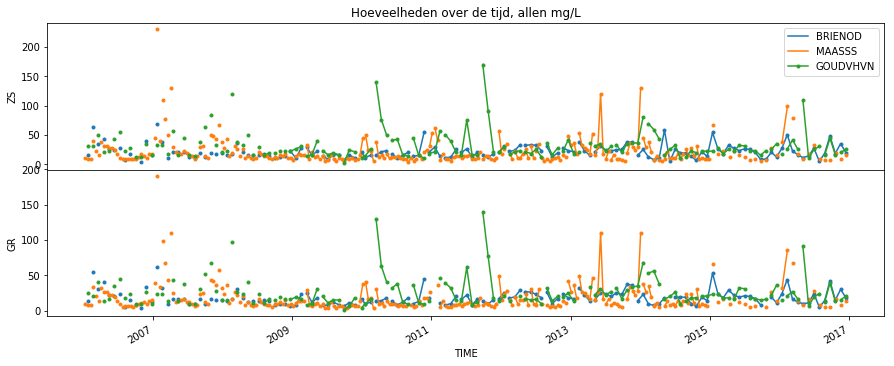

In [5]:
vergelijk_locaties(['BRIENOD', 'MAASSS', 'GOUDVHVN'], ['ZS', 'GR'])# 'DOC'])

### Westerschelde en Schelde
In onderste, lijkt verdunning plaats te vinden. Zou me niet verbazen als
de waarden kleiner worden hoe Westerlijker.

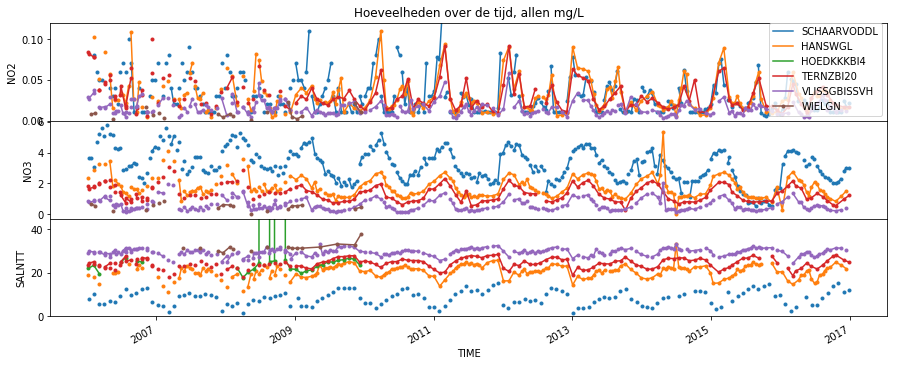

In [27]:
fig,ax = vergelijk_locaties(['SCHAARVODDL'] + ['HANSWGL', 'HOEDKKKBI4', 'TERNZBI20', 'VLISSGBISSVH',
                                      'WIELGN'],
                            [('NO2', (0,0.12)), 'NO3', ('SALNTT', (0,45))])# ('Ql', (0,8000))])

fig.savefig("img/vergelijk_loc_schelde.png")

In [7]:
from sklearn.linear_model import HuberRegressor# LinearRegression

/home/jasper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: generator 'close_in_time_gen' raised StopIteration


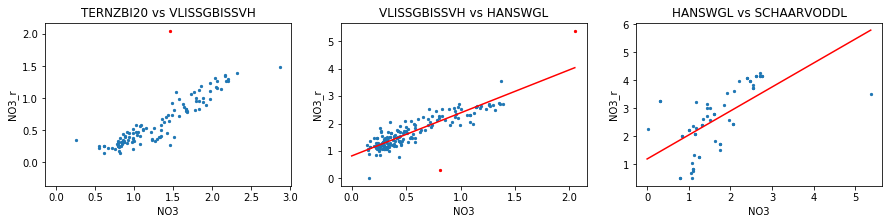

In [8]:
fig,ax = plt.subplots(1,3, figsize=(15,3))

lins = {}

for n,(l1,l2) in enumerate([('TERNZBI20','VLISSGBISSVH'), ('VLISSGBISSVH','HANSWGL'),
                           ('HANSWGL', 'SCHAARVODDL')]):
    prox = close_in_time_df(df[df.LOC==l1], df[df.LOC==l2], df.keys())
# If LinearRegression had a "drop worst one/two" function, i'd use that..
# (also, why can't i find any method with regards to the error...)
    ldf = prox[~prox.NO3.isna() & ~prox.NO3_r.isna()]
    curlin = HuberRegressor(epsilon=4).fit(ldf[['NO3']], ldf.NO3_r)
    lins[(l1,l2)] = curlin

    ldf[~curlin.outliers_].plot.scatter('NO3', 'NO3_r', marker='.', ax=ax[n])
    if any(curlin.outliers_):
        ldf[curlin.outliers_].plot.scatter('NO3', 'NO3_r', marker='.', ax=ax[n], color='red')
    max_NO3 = max(prox.NO3)
    ax[n].plot([0, max_NO3], [curlin.intercept_, curlin.intercept_+curlin.coef_*max_NO3],
              color='red')
    ax[n].set_title(l1 + " vs " + l2)

In [9]:
convs = {k:(v.intercept_,v.coef_[0]) for k,v in lins.items()}

def comb_lins(a,b, c,d): return a+b*c, b*d
convs[('VLISSGBISSVH','SCHAARVODDL')] = comb_lins(*convs[('VLISSGBISSVH', 'HANSWGL')],
                                                  *convs[('HANSWGL', 'SCHAARVODDL')])
convs[('TERNZBI20', 'SCHAARVODDL')] = comb_lins(*convs[('TERNZBI20', 'VLISSGBISSVH')],
                                                *convs[('VLISSGBISSVH','SCHAARVODDL')])

convs[('SCHAARVODDL', 'SCHAARVODDL')] = (0,1)

### Met de fits allen naar SCHAARVODDL trekken

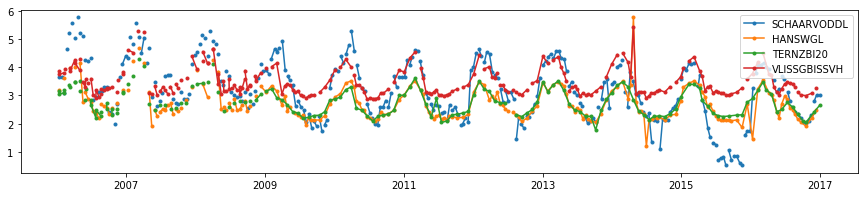

In [10]:
fig,ax = plt.subplots(1,1, figsize=(15,3))

def show_1(loc, i_no3=0, c_no3=1):
    cdf = df[df.LOC==loc]
    ax.plot(cdf.TIME, i_no3 + c_no3*cdf.NO3, label=loc, marker='.')

for loc in ['SCHAARVODDL', 'HANSWGL', 'TERNZBI20', 'VLISSGBISSVH']:
    show_1(loc, *convs[(loc, 'SCHAARVODDL')])

ax.legend(['SCHAARVODDL', 'HANSWGL', 'TERNZBI20', 'VLISSGBISSVH'])

/home/jasper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: generator 'close_in_time_gen' raised StopIteration


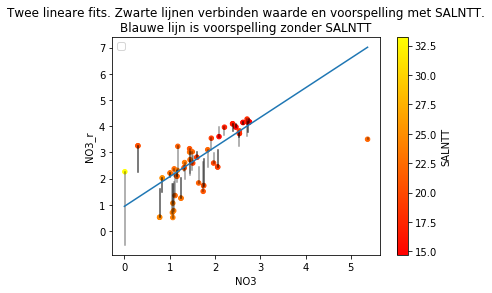

In [26]:
l1,l2 = ('HANSWGL', 'SCHAARVODDL')
prox = close_in_time_df(df[(df.LOC==l1)], df[(df.LOC==l2)], df.keys())

# Saliniteit help schijnbaar, waarschijnlijk gerelateert aan stroomsnelheid/richting.
# PLT:X lijkt lang niet zo goed te werken.
fitby = ['NO3', 'SALNTT']

sel = ~prox['NO3_r'].isna() & ~prox.NO3.isna() & ~prox.SALNTT.isna()

#for k in fitby:  # ugh..
#    sel = (sel & ~(cdf[k].isna()))

cdf = prox[sel]
fit = HuberRegressor().fit(cdf[fitby], cdf['NO3_r'])
fit2 = HuberRegressor().fit(cdf[['NO3']], cdf['NO3_r'])

fig,ax = plt.subplots()

cdf.plot.scatter('NO3', 'NO3_r', c='SALNTT', cmap='autumn', label="werkelijke meting", ax=ax)
#ax.scatter(cdf.NO3, fit.predict(cdf[fitby]), color='red', marker='.')
for no3,no3p,no3r in zip(cdf.NO3, fit.predict(cdf[fitby]), cdf.NO3_r):
    ax.plot([no3,no3], [no3p,no3r], color='black', alpha=0.4)

#ax.legend(["lijn naar voorspelde", "Werkelijke meting"])

ax.set_title("""Twee lineare fits. Zwarte lijnen verbinden waarde en voorspelling met SALNTT.
Blauwe lijn is voorspelling zonder SALNTT""")
ax.set_xlabel("NO3")


# Hmm, not straightforward. (and, of course the fit does not come with anything..)
ic = fit2.intercept_# + cdf.SALNTT.mean()*fit.coef_[1]
ax.plot([0,max(cdf.NO3)], [ic, ic + fit2.coef_[0]*max(cdf.NO3)])
ax.legend([])

fig.savefig("img/schelde_loc_comp_NO3_SALNTT.png")

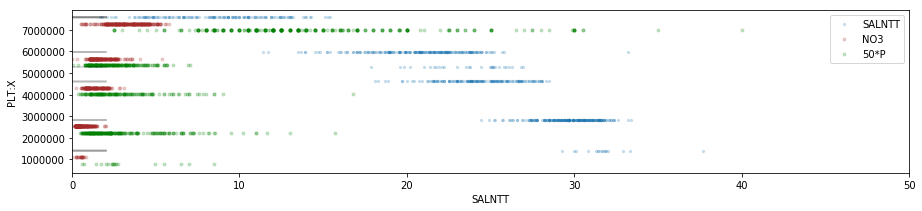

In [12]:
fig,ax = plt.subplots(1,1, figsize=(15,3))

locs = ['SCHAARVODDL'] + ['HANSWGL', 'HOEDKKKBI4', 'TERNZBI20', 'VLISSGBISSVH', 'WIELGN']
for loc in locs:
    here = df[df['LOC']==loc]
    here.plot.scatter('SALNTT','PLT:X', ax=ax, xlim=(0,50), marker='.', alpha=0.2)
    ax.scatter(here.NO3, here['PLT:X']-3e5, color='brown', marker='.', alpha=0.2)
    ax.scatter(50*here.P, here['PLT:X']-6e5, color='green', marker='.', alpha=0.2)

ax.legend(['SALNTT', 'NO3', "50*P"])

for loc in locs:
    for x in df[df['LOC']==loc]['PLT:X'].unique():
        ax.plot([0,2], [x,x], color='black', alpha=0.2)

### Oosterschelpe, STEENBGN, OESTDM

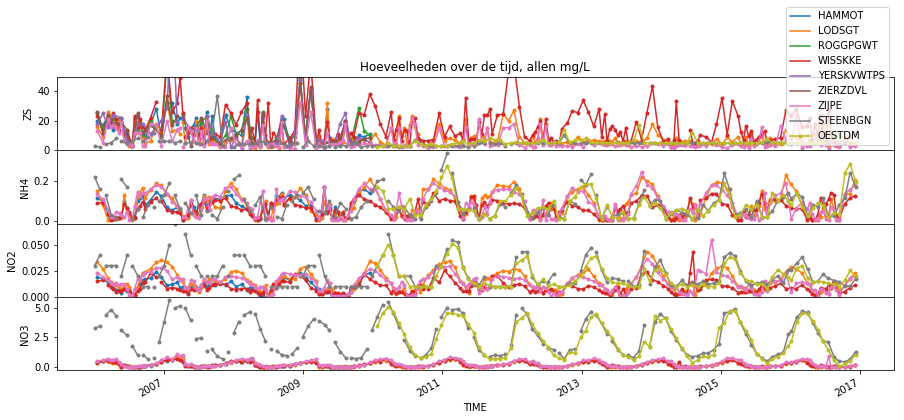

In [13]:
vergelijk_locaties(['HAMMOT', 'LODSGT', 'ROGGPGWT', 'WISSKKE', 'YERSKVWTPS', 'ZIERZDVL',
                    'ZIJPE', 'STEENBGN', 'OESTDM'],
                   [('ZS', (0,50)), 'NH4', ('NO2', (0,0.07)),'NO3'])

### Noordzee kanaal, PAMPOT

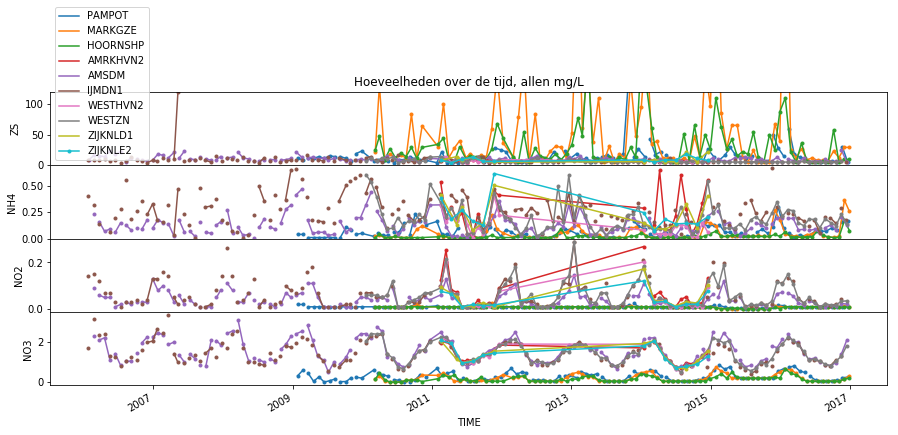

In [14]:
vergelijk_locaties(['PAMPOT', 'MARKGZE', 'HOORNSHP'] + ['AMRKHVN2', 'AMSDM', 'IJMDN1',
                                                        'WESTHVN2', 'WESTZN', 'ZIJKNLD1',
                                                        'ZIJKNLE2'],
                   [('ZS', (0,120)), ('NH4', (0,0.7)),'NO2', 'NO3'])

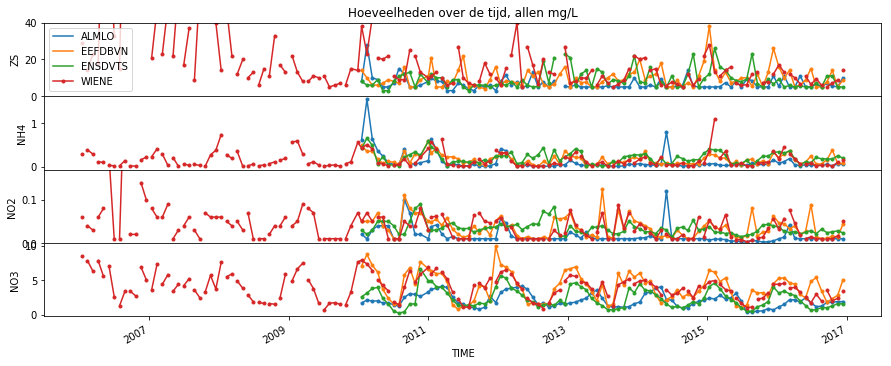

In [15]:
vergelijk_locaties(['ALMLO', 'EEFDBVN', 'ENSDVTS', 'WIENE'],
                  [('ZS', (0,40)), 'NH4', ('NO2', (0,0.17)), 'NO3'])

In [16]:
list(loc_df[loc_df.gbd=='OOSTSDE']['loc'].unique())

['HAMMOT', 'LODSGT', 'ROGGPGWT', 'WISSKKE', 'YERSKVWTPS', 'ZIERZDVL', 'ZIJPE']

NameError: name 'loc_df' is not defined

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(15,4))

prox.plot.scatter('NO2', 'NO2_r', marker='.', ax=ax[0], alpha=0.4)
prox.plot.scatter('NO3', 'NO3_r', marker='.', ax=ax[1], alpha=0.4)